In [1]:
# packages to store and manipulate data
import numpy as np
import pandas as pd

# packages to train model
import torch
import transformers
import warnings

warnings.filterwarnings('ignore')

In [2]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce RTX 2080 Ti


In [3]:
# load datasets into pandas dataframe
df_training = pd.read_csv('../data/raw/task1_training.tsv', sep='\t')
df_validation = pd.read_csv('../data/raw/task1_validation.tsv', sep='\t')

In [4]:
# Report the number of sentences in each datasets.
print('Number of training sentences: {:,}\n'.format(df_training.shape[0]))
print('Number of validation sentences: {:,}\n'.format(df_validation.shape[0]))

Number of training sentences: 55,419

Number of validation sentences: 13,853



In [5]:
df_training['class'].value_counts()

0    55273
1      146
Name: class, dtype: int64

In [6]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


#### Apply tokenizer to datasets

In [7]:
train_tokenized = df_training['tweet'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
validate_tokenized = df_validation['tweet'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

In [8]:
# Print sentence 0, now as a list of IDs.
print('Original: ', len(df_training.iloc[0]['tweet'].split()))
print('Token IDs:', len(train_tokenized[0]))

Original:  26
Token IDs: 36


#### Padding

In [9]:
# get the max length of sentences from both train and validation sets
train_max_length = max(len(x) for x in train_tokenized)
validate_max_length = max(len(x) for x in validate_tokenized)
MAX_LEN = max(train_max_length, validate_max_length)

In [10]:
# pad token so that they all have the same size
train_padded = np.array([i + [0]*(MAX_LEN-len(i)) for i in train_tokenized.values])
validate_padded = np.array([i + [0]*(MAX_LEN-len(i)) for i in validate_tokenized.values])

In [11]:
train_padded.shape

(55419, 81)

In [12]:
validate_padded.shape

(13853, 81)

### Masking

In [13]:
train_attention_mask = np.where(train_padded != 0, 1, 0)
validate_attention_mask = np.where(validate_padded != 0, 1, 0)

In [14]:
train_attention_mask.shape

(55419, 81)

In [15]:
validate_attention_mask.shape

(13853, 81)

### Convert to PyTorch Data Types

In [16]:
train_labels = df_training['class'].values
validate_labels = df_validation['class'].values

In [17]:
len(validate_labels)

13853

In [18]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_padded)
validation_inputs = torch.tensor(validate_padded)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validate_labels)

train_masks = torch.tensor(train_attention_mask)
validation_masks = torch.tensor(validate_attention_mask)

In [19]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

### Train Classification Model

In [20]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [21]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [22]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [23]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [24]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [25]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [26]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 1000 batches.
        if step % 1000 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch 1,000  of  3,464.    Elapsed: 0:01:47.
  Batch 2,000  of  3,464.    Elapsed: 0:03:35.
  Batch 3,000  of  3,464.    Elapsed: 0:05:23.

  Average training loss: 0.01
  Training epcoh took: 0:06:13

Running Validation...
  Accuracy: 1.00
  Validation took: 0:00:26

======== Epoch 2 / 4 ========
Training...
  Batch 1,000  of  3,464.    Elapsed: 0:01:47.
  Batch 2,000  of  3,464.    Elapsed: 0:03:33.
  Batch 3,000  of  3,464.    Elapsed: 0:05:19.

  Average training loss: 0.00
  Training epcoh took: 0:06:08

Running Validation...
  Accuracy: 1.00
  Validation took: 0:00:26

======== Epoch 3 / 4 ========
Training...
  Batch 1,000  of  3,464.    Elapsed: 0:01:46.
  Batch 2,000  of  3,464.    Elapsed: 0:03:33.
  Batch 3,000  of  3,464.    Elapsed: 0:05:20.

  Average training loss: 0.00
  Training epcoh took: 0:06:09

Running Validation...
  Accuracy: 1.00
  Validation took: 0:00:26

======== Epoch 4 / 4 ========
Training...
  Batch 1,000  of 

### Training loss over batches

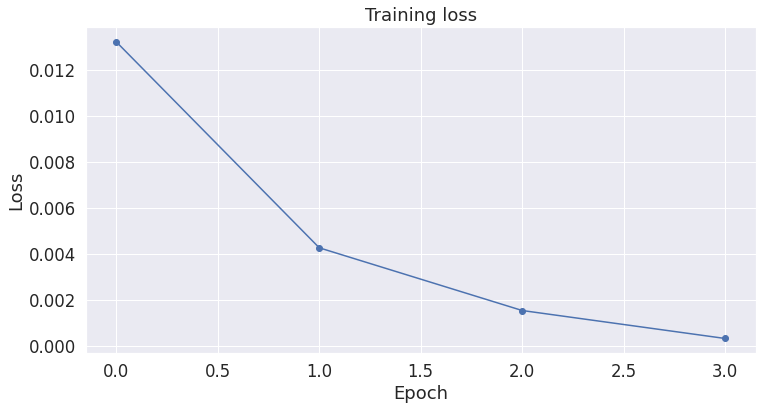

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [28]:
# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model.save_pretrained('../models/')
tokenizer.save_pretrained('../models/')

('../models/vocab.txt',
 '../models/special_tokens_map.json',
 '../models/added_tokens.json')

### Evaluate on Test Set

In [29]:
df_test = pd.read_csv('../data/raw/AnnotationDRUGSInTweets_EMNLPChallenge18_TrainingSetClean.tsv', sep='\t')

In [30]:
# Report the number of tweets.
print('Number of test sentences: {:,}\n'.format(df_test.shape[0]))

Number of test sentences: 9,622



In [31]:
# Tokenize all of the texts and map tokens to their word IDs
test_tokenized = df_test['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

In [32]:
# get the max length of texts
test_max_length = max(len(x) for x in test_tokenized)

In [33]:
# Pad all texts to the same size
test_padded = np.array([i + [0]*(test_max_length-len(i)) for i in test_tokenized.values])

In [34]:
# Create a mask of 1s for each token followed by 0s for padding
attention_mask = np.where(test_padded != 0, 1, 0)

In [35]:
labels = df_test.label.values

In [36]:
# Convert to tensors.
prediction_inputs = torch.tensor(test_padded)
prediction_masks = torch.tensor(attention_mask)
prediction_labels = torch.tensor(labels)

In [37]:
batch_size = 16

In [38]:
# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [39]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 9,622 test sentences...
    DONE.


In [40]:
print('Positive samples: %d of %d (%.2f%%)' % (df_test.label.sum(), len(df_test.label), (df_test.label.sum() / len(df_test.label) * 100.0)))

Positive samples: 4975 of 9622 (51.70%)


In [41]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [42]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.462


In [43]:
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score

# Calculate the evaluation metrics
print(f'F1 score: {f1_score(flat_true_labels, flat_predictions)}')
print(f'Accuracy: {accuracy_score(flat_true_labels, flat_predictions)}')
print(f'Precision: {precision_score(flat_true_labels, flat_predictions)}')
print(f'Recall: {recall_score(flat_true_labels, flat_predictions)}')

F1 score: 0.5888324873096447
Accuracy: 0.68852629390979
Precision: 0.9273984442523768
Recall: 0.431356783919598


####  Evaluation metrics for the “positive” class

In [44]:
# Get positive labels
np_true_labels = np.array(flat_true_labels)
positive_labels_index = np.where(np_true_labels==1)
positive_labels = np_true_labels[positive_labels_index]

In [45]:
# Get prediction labels
np_predictions = np.array(flat_predictions)
positive_predictions = np_predictions[positive_labels_index]

In [46]:
# Calculate the F1 score for positive class
print(f'F1 score: {f1_score(positive_predictions, positive_labels)}')

F1 score: 0.602724336469597
